# Imports/utility functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import gc, os, cna, warnings
import scanpy as sc
import vima.data.samples as vds
import vima.data.patchcollection as vdp
import vima.vis as vv
from PIL import Image
fs_axislabel = 10
fs_figsubpanel = 14
fs_legend = 8

# Prepare

## read data

In [443]:
d = cna.read('_results/default-vae.h5ad'); d.sampleid = 'sid'

# read in cells
cells = pd.read_csv('../../ALZ/alz-data/SEAAD_MTG_MERFISH_metadata.2024-05-03.noblanks.harmonized.txt', sep='\t')
cells['sid'] = cells.Section.str.split('_').str[1]
coarsecelltypes = cells.class_name.unique()
celltypes = cells.subclass_name.unique()
subcelltypes = cells.supertype_name.unique()

# read in samples
repname = 'pca_k=10_harmony'
samples = vds.read_samples(f'../../ALZ/alz-data/10u/{repname}/*.nc', vds.default_parser)

# # make patches
# P = vdp.PatchCollection(
#     vds.choose_patches(samples, patchsize, patchstride, max_frac_empty=0.8),
#                         samples, standardize=True)
# sid_nums = {sid:sid_num for sid, sid_num in P.meta[['sid','sid_num']].drop_duplicates().values}

# # choose which patches to do case/ctrl analysis on
# Pdense = vdp.PatchCollection(
#     vds.choose_patches(samples, patchsize, patchstride, max_frac_empty=0.2),
#                         samples, sid_nums=sid_nums, standardize=True)

100%|███████████████████████████████████████████████████████████████| 75/75 [00:09<00:00,  7.63it/s]


# Main case-control figure

In [467]:
from sklearn.metrics import roc_curve, auc
def roc(ax):
    fpr, tpr, thresholds = roc_curve(d.samplem.case, d.samplem.yhat)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkgoldenrod', lw=2, zorder=1000)
    ax.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
    ax.set_xlabel("False Positive Rate", fontsize=fs_axislabel)
    ax.set_ylabel("True Positive Rate", fontsize=fs_axislabel)
    ax.set_xlim([-0.02,1.02]); ax.set_ylim([-0.02,1.02])
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.text(0.95, 0.05, f"AUROC: {roc_auc:.2f}", ha='right', va='bottom', fontsize=fs_axislabel, fontweight='medium')
    ax.spines[['top','right']].set_visible(False)

from io import BytesIO
from PIL import Image
def spatial_locations(ax, ncols, sids):
    sortkey = pd.Series(range(len(sids)), index=sids)
    fig = vv.spatialplot(samples,
                   sortkey,
                   d.obs,
                   [(d.obs['L2/3 IT'] / d.obs.totalcells).fillna(0), (d.obs['L6b']*5 / d.obs.totalcells).fillna(0)],
                   rgbs=[[0.,0.8,0.],[0/255., 195/255., 255/255.]],
                   labels=d.samplem.case.map({True:'Dementia',False:'Control'}),
                   label_fontsize=fs_axislabel,
                   highlights=[d.obs.ncorr_thresh > 0, d.obs.ncorr_thresh < 0],
                   outline_rgbas=[[1,0,0,1],[0,0,1,1]], outline_thickness=15,
                   skipthresh=200, skipevery=1,
                   vmax=5, ncols=ncols, size=2, show=False)
    fig.tight_layout()
    buff = BytesIO()
    fig.savefig(buff, format="png", bbox_inches="tight", dpi=800)
    plt.close(fig)
    buff.seek(0)
    ax.imshow(Image.open(buff))
    ax.axis('off')

from matplotlib.patches import Rectangle
def spatial_legend(ax):
    lines = [
        plt.scatter([],[], marker='o', s=5, color=[0.,0.8,0.], label='L2/3'),
        plt.scatter([],[], marker='o', s=5, color=[0/255., 195/255., 255/255.], label='L6'),
        plt.scatter([],[], marker='o', facecolors='none', linewidths=2, s=5, color=[1, 0, 0], label='Dementia-associated'),
        plt.scatter([],[], marker='o', facecolors='none', linewidths=2, s=5, color=[0, 0, 1], label='Control-associated'),
    ]
    legend = ax.legend(handles=lines, loc="center", markerscale=2, ncols=4, frameon=False,
                       columnspacing=0.3, handletextpad=0.01,
                       fontsize=fs_legend, labelcolor='white')
    bbox = legend.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
    rect = Rectangle(
        (bbox.x0, bbox.y0),
        bbox.width,
        bbox.height,
        transform=ax.transAxes,
        color="black",
        zorder=legend.get_zorder() - 1
    )
    ax.add_patch(rect)
    ax.axis('off')

from matplotlib.patheffects import withStroke
def umap(ax):    
    sc.pl.umap(d, ax=ax, show=False, s=2)
    sc.pl.umap(d[d.obs.ncorr_thresh != 0], color='ncorr_thresh', cmap='seismic', vmin=-1, vmax=1, s=7, ax=ax, show=False,
               colorbar_loc=None, frameon=False, title='')

    p = 0.0023499765002349977
    formatted = f"${p:.1e}"
    formatted_latex = formatted.replace('-0', '-').replace("e", r" \times 10^{").replace("+", "").replace("-", r"-") + "}$"
    ax.text(1.5, -2, f'P={formatted_latex}', ha='left', va='bottom', fontsize=fs_legend, fontweight='medium')
    
    fontprops = {'fontsize':fs_axislabel, 'fontweight':'bold', 'color':'black', 'ha':'center', 'va':'center'}
    for i, cond in enumerate([d.obs.ncorr_thresh < 0, d.obs.ncorr_thresh > 0]):
        text = ax.text(*np.median(d.obsm['X_umap'][cond], axis=0), str(i+1), **fontprops)
        text.set_path_effects([withStroke(linewidth=3, foreground='white')])

def violinplot(ax, cts):
    if cts is None:
        cts = celltypes
    pos = (d.obs.L6b / d.obs.totalcells >= 0.05) & (d.obs.ncorr_thresh > 0)
    neg = (d.obs.L6b / d.obs.totalcells >= 0.05) & (d.obs.ncorr_thresh <= 0)
    vv.diff_markers(d.obs[celltypes].div(d.obs.totalcells, axis=0).fillna(0),
                    d.obs[pos].index, d.obs[neg].index, cts,
                    labels=['Dementia-associated L6','Other L6'], nmarkers=4, ascending=False, ax=ax, show=False,
                    split=True, inner='quart', density_norm='count',
                    palette={'Dementia-associated L6': "red", 'Other L6': "#00C3FF"})
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, title=None)
    ax.set_ylabel('Prop. cells in patch')
    ax.set_yticks([0,0.5])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
    ax.spines[['right','top']].set_visible(False)

from scipy.stats import ks_2samp
def twosample(ax, name, xlabel, alternative, px, py):
    def ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(x)+1) / len(x)
        return x, y
    case = d.samplem[d.samplem.case][name]
    ctrl = d.samplem[~d.samplem.case][name]
    ax.plot(*ecdf(case), color='red', label='Dementia')
    ax.plot(*ecdf(ctrl), color='blue', label='Control')
    ax.set_xlabel(xlabel, fontsize=fs_axislabel)
    ax.set_ylabel('Prop. samples')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.spines[['right','top']].set_visible(False)
    ax.legend(fontsize=fs_legend)

    p = ks_2samp(case, ctrl, alternative=alternative).pvalue
    formatted = f"${p:.1e}"
    formatted_latex = formatted.replace('-0', '-').replace("e", r" \times 10^{").replace("+", "").replace("-", r"-") + "}$"
    ax.text(px, py, f'P={formatted_latex}', ha='left', va='top', fontsize=fs_legend, fontweight='medium')

/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_98918/3198795581.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sids = d.samplem[d.obs.sid.value_counts() > 200].sort_values(by='sortkey').iloc[


............

/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_98918/1224017140.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)


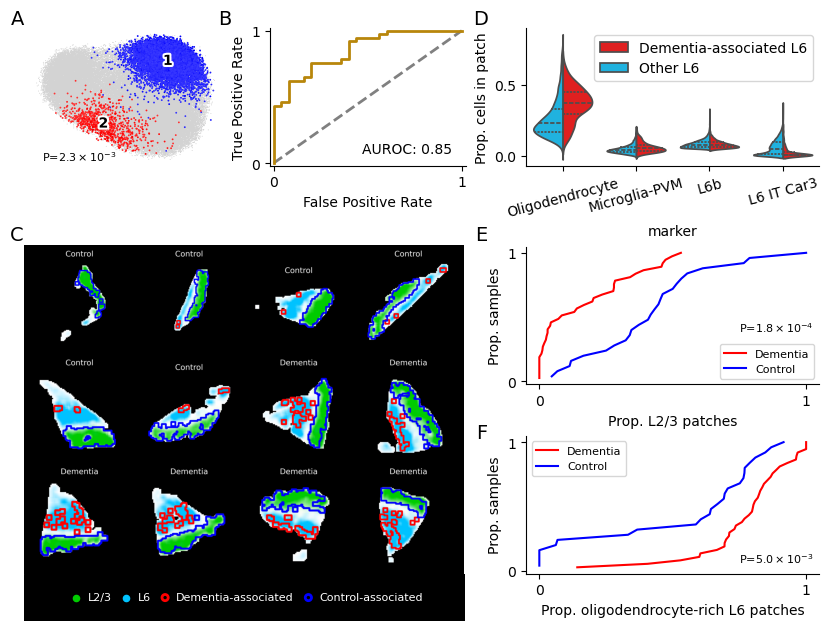

In [469]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8,6), constrained_layout=True)
width_ratios = np.array([1, 1, 1.5])
height_ratios = np.array([1, 1, 1])
spatial_width = width_ratios[:2].sum() / width_ratios.sum() - 0.02
spatial_height = height_ratios[1:].sum() / height_ratios.sum() - 0.04
gs = GridSpec(3, 3, width_ratios=width_ratios, height_ratios=height_ratios, figure=fig)

d.samplem['sortkey'] = d.samplem.npos / (d.samplem.nneg + 1)
sids = d.samplem[d.obs.sid.value_counts() > 200].sort_values(by='sortkey').iloc[
    [0,10,11,14,16,18] + #control
    [26,27,28,31,32,36]].index

umap(fig.add_subplot(gs[0,0]))
roc(fig.add_subplot(gs[0,1]))
spatial_locations(fig.add_axes([0, spatial_height / 8, spatial_width, 7*spatial_height/8]), 4, sids)
spatial_legend(fig.add_axes([0, 0, spatial_width, spatial_height/8]))

violinplot(fig.add_subplot(gs[0,2]), ['Oligodendrocyte','Microglia-PVM','L6b','L6 IT Car3'])
twosample(fig.add_subplot(gs[1,2]), 'frac_layer23', 'Prop. L2/3 patches', 'greater', 0.75, 0.48)
twosample(fig.add_subplot(gs[2,2]), 'frac_layer6_manyoligo', 'Prop. oligodendrocyte-rich L6 patches', 'less', 0.75, 0.15)

# subpart labels
fig.text(0, 1.02, 'A', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0.26, 1.02, 'B', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0, 0.66, 'C', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0.58, 1.02, 'D', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0.58, 0.66, 'E', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0.58, 0.33, 'F', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')

fig.savefig('../_main/fig.ALZ.pdf', bbox_inches='tight', dpi=800)
plt.show()